In [30]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is not available. Working on CPU


In [8]:
def listdir_nohidden(path):
    dirs = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            dirs.append(f)
    return dirs

In [17]:
DIR_MAIN = 'data/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_TEST = DIR_MAIN + 'test/'

# Number of labels - 200
labels = listdir_nohidden(DIR_TRAIN)
# print(labels)
# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training 
files_train = []
labels_train = []
for label in labels:
    for filename in listdir_nohidden(DIR_TRAIN + label +'/'):
        files_train.append(DIR_TRAIN + label + '/' + filename)
        labels_train.append(label)

# Create lists of files and labels for validation 30% of original train
train_idx, val_idx = train_test_split(list(range(len(files_train))), test_size=0.3)
files_val = [files_train[idx] for idx in val_idx]
labels_val = [labels_train[idx] for idx in val_idx]
files_train = [files_train[idx] for idx in train_idx]
labels_train = [labels_train[idx] for idx in train_idx]


# List of files for testing (10'000 items)
files_test = []
labels_test = []
for label in labels:
    for filename in listdir_nohidden(DIR_TEST + label + '/'):
        files_test.append(DIR_TEST + label + '/' + filename)
        labels_test.append(label)
    
print("Sample files from the list of train images:", files_train[:5])
print("\nSample labels from the list of train labels:", labels_train[:5])
print("\nSample files from the list of validation images:", files_val[:5])
print("\nSample labels from the list of validation labels:", labels_val[:5])
print("\nSample files from the list of test images:", files_test[:5])
print("\nSample labels from the list of test labels:", labels_test[:5])

The first five files from the list of train images: ['data/train/happy/Training_63038025.jpg', 'data/train/neutral/Training_30531080.jpg', 'data/train/surprise/Training_99576616.jpg', 'data/train/fear/Training_40226803.jpg', 'data/train/sad/Training_33044906.jpg']

The first five labels from the list of train labels: ['happy', 'neutral', 'surprise', 'fear', 'sad']

The first five files from the list of validation images: ['data/train/happy/Training_79964605.jpg', 'data/train/happy/Training_95611600.jpg', 'data/train/sad/Training_82757224.jpg', 'data/train/fear/Training_95389837.jpg', 'data/train/happy/Training_18925796.jpg']

The first five labels from the list of validation labels: ['happy', 'happy', 'sad', 'fear', 'happy']

The first five files from the list of test images: ['data/test/happy/PrivateTest_45699463.jpg', 'data/test/happy/PrivateTest_61855708.jpg', 'data/test/happy/PublicTest_53681781.jpg', 'data/test/happy/PrivateTest_52109800.jpg', 'data/test/happy/PublicTest_41104919.

In [22]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

In [24]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

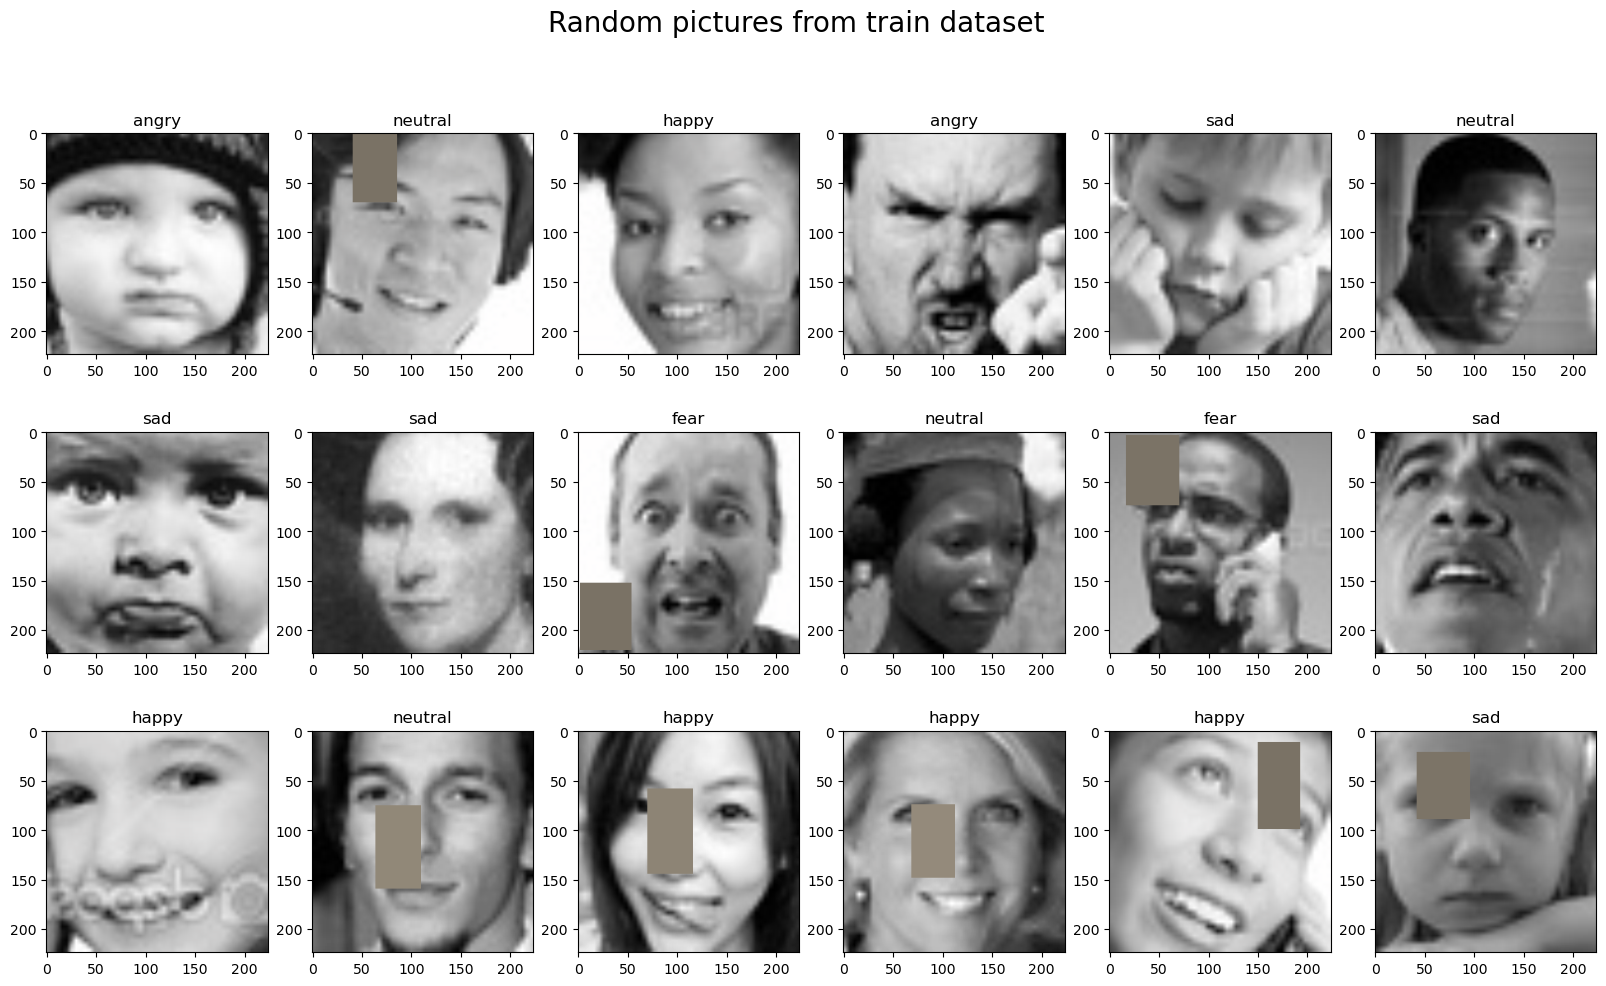

In [29]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

test_dataset = ImagesDataset(files=files_test,
                             labels=labels_test,
                             encoder=encoder_labels,
                             transforms=transforms_val,
                             mode='test')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    # img = np.clip(img, 0, 1)
    # print(np.max(img))
    img = img/np.max(img)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

In [31]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    

In [33]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show()

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
num_epochs = 5

In [35]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=7)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

/Users/juniorbentamo/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/juniorbentamo/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /Users/juniorbentamo/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100.0%
  0%|          | 0/5 [00:00<?, ?it/s]/Users/juniorbentamo/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:371: Us

Epoch: 1 | Learning rate: [0.0003]


  0%|          | 0/5 [13:08<?, ?it/s]


KeyboardInterrupt: 